# A reconstruction nosie dependence on CMB white noise level
This code compute normalization and power spectrum of quadratic estiamtors with varying CMB noise level

In [2]:
# external
import numpy as np
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as plc

First define parameters

In [34]:
Tcmb  = 2.726e6    # CMB temperature
Lmin, Lmax  = 2, 4096       # maximum multipole of output normalization
rlmin, rlmax = 100, 4096  # CMB multipole range for reconstruction
dlmin, dlmax = 2, 2048    # lensing template
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)
ac2rad = np.pi/10800.

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [4]:
# ucl is an array of shape [0:5,0:rlmax+1] and ucl[0,:] = TT, ucl[1,:] = EE, ucl[2,:] = TE, lcl[3,:] = phiphi, lcl[4,:] = Tphi
ucl = basic.aps.read_cambcls('../data/unlensedcls.dat',2,rlmax,5)/Tcmb**2 # TT, EE, TE, pp, Tp
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,rlmax,4,bb=True)/Tcmb**2 # TT, EE, BB, TE

Loop over SNR calculation

In [19]:
sigs = [5.,3.,1.,.5,.1]
Ag = {}
for i, sig in enumerate(sigs):
    nl  = np.zeros((4,rlmax+1))
    nl[0,:] = (sig*ac2rad/Tcmb)**2
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    ocl = lcl + nl
    Ag[i], __ = cs.norm_lens.qeb_iter(Lmax,rlmax,rlmin,rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:],ucl[3,:],iter=50)

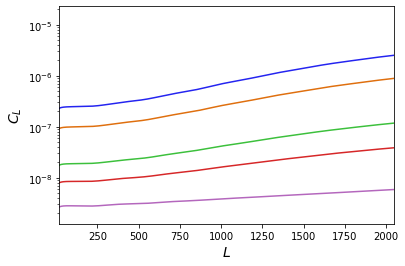

In [23]:
plc.plot_1dstyle(ylog=True)
for i in range(len(sigs)):
    plot(L,L**4*Ag[i])

In [16]:
#AlEB, __ = cs.norm_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])

In [39]:
rbb = {}
for i in range(len(sigs)):
    WE = np.ones((dlmax+1))
    Wp = ucl[3,:]/(ucl[3,:]+Ag[i])
    rbb[i] = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE, Wp[:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [40]:
bb = basic.delens.lensingbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages

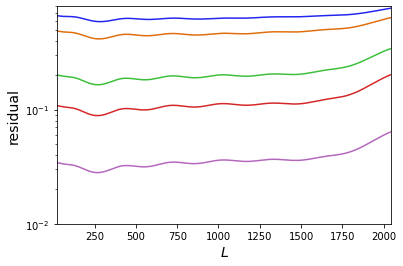

In [45]:
plc.plot_1dstyle(ymin=.01,ymax=.8,ylog=True,ylab='residual')
for i in range(len(sigs)):
    plot(L[:dlmax+1],rbb[i]/bb)